#**TELECOM X Parte 2**

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ===============================
# 1) Cargar dataset
# ===============================
df = pd.read_csv('df_limpo.csv')
df



,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,Total.Day,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,2.20,65.60,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,2.01,59.90,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,2.34,73.90,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.17,98.00,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.97,83.90,267.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,No,Female,0,No,No,13,Yes,No,DSL,...,No,Yes,No,No,One year,No,Mailed check,1.90,55.15,742.90
7039,9992-RRAMN,Yes,Male,0,Yes,No,22,Yes,Yes,Fiber optic,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,2.84,85.10,1873.70
7040,9992-UJOEL,No,Male,0,No,No,2,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,1.55,50.30,92.75
7041,9993-LHIEB,No,Male,0,Yes,Yes,67,Yes,No,DSL,...,Yes,Yes,No,Yes,Two year,No,Mailed check,2.30,67.85,4627.65


In [13]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

In [16]:
# ===============================
# 2) Preprocesamiento
# ===============================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # ✅ para sklearn >= 1.4
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [17]:
# ===============================
# 3) Split train/test
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# ===============================
# 4) Modelos simplificados
# ===============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(
        n_estimators=80,     # menos árboles
        max_depth=8,         # profundidad limitada
        random_state=42,
        n_jobs=-1            # usar todos los cores
    )
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess),
                           ("classifier", model)])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results[name] = {"Accuracy": acc, "ROC_AUC": roc}

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    if roc: print("ROC AUC:", roc)
    print(classification_report(y_test, y_pred))



===== Logistic Regression =====
Accuracy: 0.7927608232789212
ROC AUC: 0.8430352114495336
              precision    recall  f1-score   support

          No       0.84      0.89      0.86      1035
         Yes       0.63      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409


===== Random Forest =====
Accuracy: 0.7345635202271115
ROC AUC: 0.825668449197861
              precision    recall  f1-score   support

          No       0.73      1.00      0.85      1035
         Yes       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


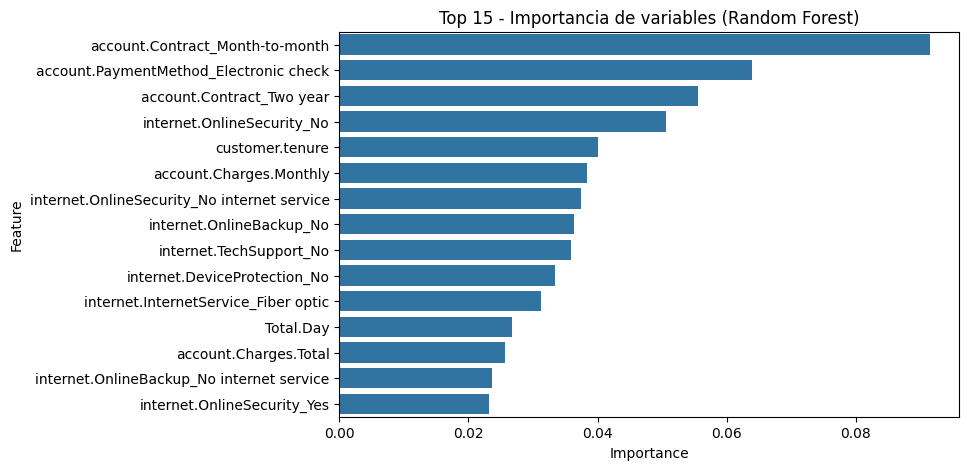

In [19]:
# ===============================
# 5) Importancia de variables (solo Random Forest)
# ===============================
rf_pipe = Pipeline(steps=[("preprocess", preprocess),
                          ("classifier", models["Random Forest"])])
rf_pipe.fit(X_train, y_train)

feature_names = (
    list(numeric_features) +
    list(rf_pipe.named_steps["preprocess"]
         .named_transformers_["cat"]
         .named_steps["onehot"]
         .get_feature_names_out(categorical_features))
)

importances = rf_pipe.named_steps["classifier"].feature_importances_
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(data=feat_imp, x="Importance", y="Feature")
plt.title("Top 15 - Importancia de variables (Random Forest)")
plt.show()

===== Resultados - Regresión Logística =====
Modelo: Regresión Logística
Train_AUC: 0.935343631546243
Test_AUC: 0.8430352114495336
Accuracy: 0.7927608232789212
Precision: 0.6331168831168831
Recall: 0.5213903743315508
F1: 0.5718475073313783
Confusion_Matrix: [[922 113]
 [179 195]]

===== Resultados - Random Forest =====
Modelo: Random Forest
Train_AUC: 0.8499276399304763
Test_AUC: 0.8286600015500272
Accuracy: 0.7345635202271115
Precision: 0.0
Recall: 0.0
F1: 0.0
Confusion_Matrix: [[1035    0]
 [ 374    0]]


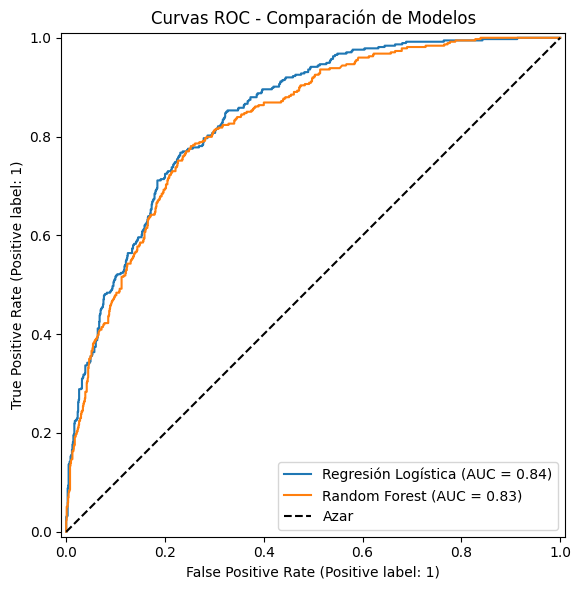

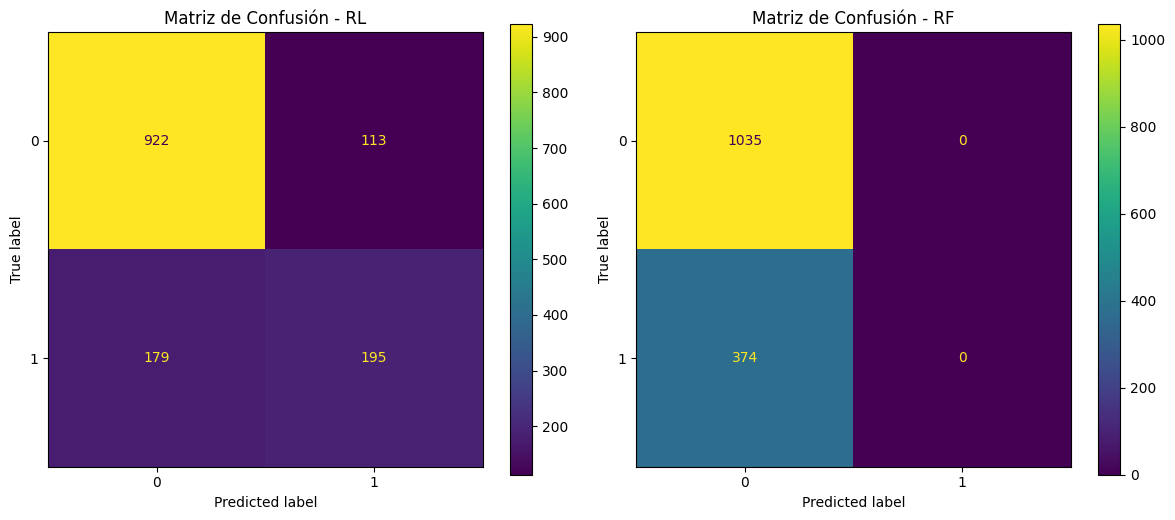


Top 15 Importancias (Random Forest):
                                          Feature  Importance
5671              account.Contract_Month-to-month    0.087925
5673                    account.Contract_Two year    0.060451
5653                   internet.OnlineSecurity_No    0.059995
5678       account.PaymentMethod_Electronic check    0.052834
1                                 customer.tenure    0.040146
4                           account.Charges.Total    0.040132
5662                      internet.TechSupport_No    0.035980
5651         internet.InternetService_Fiber optic    0.033776
5659                 internet.DeviceProtection_No    0.032964
5654  internet.OnlineSecurity_No internet service    0.032743
3                         account.Charges.Monthly    0.032717
5656                     internet.OnlineBackup_No    0.029250
5657    internet.OnlineBackup_No internet service    0.025403
5652                  internet.InternetService_No    0.023850
5655                  internet.O

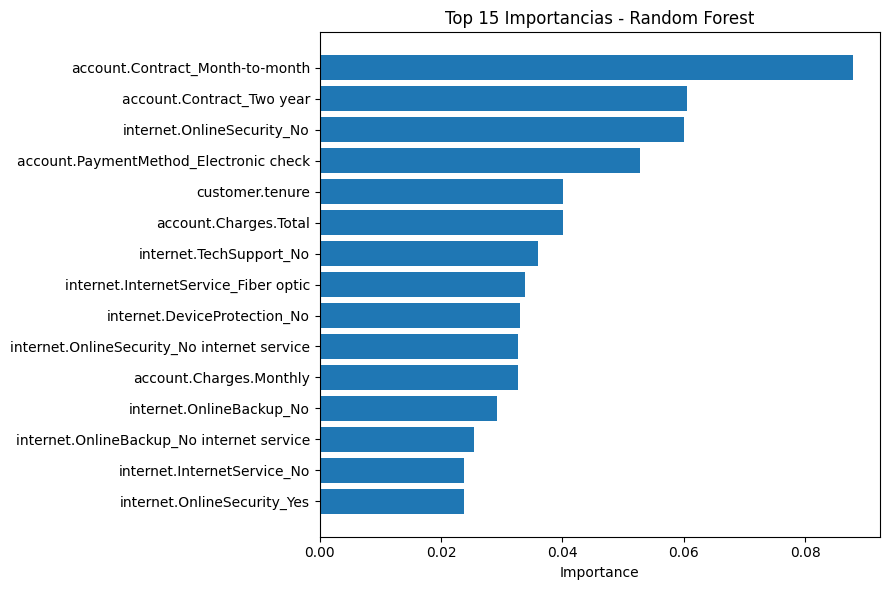


== Conclusión rápida ==
Mejor modelo: Regresión Logística — Test AUC: 0.843, F1: 0.572
Sugerencias: ajustar umbral según capacidad de retención, calibrar probabilidades y evaluar planes/soporte en segmentos de alto riesgo.


In [21]:
# ==========================================
# Pipeline Churn — RL vs RF (con gráficos)
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)

# -----------------------------
# 1) Cargar datos
# -----------------------------
df = pd.read_csv("/content/df_limpo.csv")

# Asegurar target binario 0/1 si viene como texto
if df["Churn"].dtype == object:
    df["Churn"] = df["Churn"].str.strip().map({"Yes":1, "No":0, "Y":1, "N":0, "True":1, "False":0}).fillna(df["Churn"])
# Si aún no es numérico, intenta convertir
if not np.issubdtype(df["Churn"].dtype, np.number):
    df["Churn"] = pd.to_numeric(df["Churn"], errors="coerce")
# Quitar filas sin target
df = df.dropna(subset=["Churn"])
df["Churn"] = df["Churn"].astype(int)

X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

# -----------------------------
# 2) Tipos de variables
# -----------------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# -----------------------------
# 3) Preprocesamiento
#    (usar sparse_output=False en sklearn >= 1.2)
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    verbose_feature_names_out=False
)

# -----------------------------
# 4) Split Train/Test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# -----------------------------
# 5) Definir Modelos
# -----------------------------
model_rl = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, solver="lbfgs"))
])

model_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100, max_depth=8, random_state=42, n_jobs=-1
    ))
])

# -----------------------------
# 6) Entrenar
# -----------------------------
model_rl.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

# -----------------------------
# 7) Evaluación (incluye gap train/test)
# -----------------------------
def eval_model(name, model, Xtr, ytr, Xte, yte):
    y_pred_tr = model.predict(Xtr)
    y_pred_te = model.predict(Xte)
    y_proba_tr = model.predict_proba(Xtr)[:, 1]
    y_proba_te = model.predict_proba(Xte)[:, 1]
    res = {
        "Modelo": name,
        "Train_AUC": roc_auc_score(ytr, y_proba_tr),
        "Test_AUC": roc_auc_score(yte, y_proba_te),
        "Accuracy": accuracy_score(yte, y_pred_te),
        "Precision": precision_score(yte, y_pred_te, zero_division=0),
        "Recall": recall_score(yte, y_pred_te, zero_division=0),
        "F1": f1_score(yte, y_pred_te, zero_division=0),
        "Confusion_Matrix": confusion_matrix(yte, y_pred_te)
    }
    return res

res_rl = eval_model("Regresión Logística", model_rl, X_train, y_train, X_test, y_test)
res_rf = eval_model("Random Forest", model_rf, X_train, y_train, X_test, y_test)

print("===== Resultados - Regresión Logística =====")
for k,v in res_rl.items(): print(f"{k}: {v}")
print("\n===== Resultados - Random Forest =====")
for k,v in res_rf.items(): print(f"{k}: {v}")

# -----------------------------
# 8) Curvas ROC comparadas
# -----------------------------
plt.figure(figsize=(8,6))
RocCurveDisplay.from_estimator(model_rl, X_test, y_test, name="Regresión Logística", ax=plt.gca())
RocCurveDisplay.from_estimator(model_rf, X_test, y_test, name="Random Forest", ax=plt.gca())
plt.plot([0,1],[0,1],"k--", label="Azar")
plt.title("Curvas ROC - Comparación de Modelos")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# -----------------------------
# 9) Matrices de Confusión lado a lado
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_estimator(model_rl, X_test, y_test, ax=axes[0])
axes[0].set_title("Matriz de Confusión - RL")
ConfusionMatrixDisplay.from_estimator(model_rf, X_test, y_test, ax=axes[1])
axes[1].set_title("Matriz de Confusión - RF")
plt.tight_layout()
plt.show()

# -----------------------------
# 10) Importancia de variables (RF) y Coeficientes (RL)
# -----------------------------
# Nombres de features transformados (num + OHE cat)
def get_feature_names_from_preprocessor(fitted_preprocessor, num_cols, cat_cols):
    names = []
    # num
    names.extend(num_cols)
    # cat (OHE)
    if len(cat_cols) > 0:
        ohe = fitted_preprocessor.named_transformers_["cat"].named_steps["encoder"]
        names.extend(list(ohe.get_feature_names_out(cat_cols)))
    return names

feature_names = get_feature_names_from_preprocessor(
    model_rf.named_steps["preprocessor"], num_cols, cat_cols
)

# Importancias RF
rf_importances = model_rf.named_steps["classifier"].feature_importances_
imp_rf = pd.DataFrame({"Feature": feature_names, "Importance": rf_importances}).sort_values(
    by="Importance", ascending=False
)

print("\nTop 15 Importancias (Random Forest):")
print(imp_rf.head(15))

# Coeficientes RL (signo indica dirección del efecto en log-odds)
try:
    coefs = model_rl.named_steps["classifier"].coef_[0]
    imp_rl = pd.DataFrame({"Feature": feature_names, "Coeficiente": coefs}).sort_values(
        by="Coeficiente", ascending=False
    )
    print("\nTop 10 Coeficientes positivos (RL):")
    print(imp_rl.head(10))
    print("\nTop 10 Coeficientes negativos (RL):")
    print(imp_rl.tail(10))
except Exception as e:
    print("\nNo se pudieron extraer coeficientes de RL:", e)

# -----------------------------
# 11) Gráfico Top Importancias RF
# -----------------------------
topN = imp_rf.head(15)
plt.figure(figsize=(9,6))
plt.barh(topN["Feature"][::-1], topN["Importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Importancias - Random Forest")
plt.tight_layout()
plt.show()

# -----------------------------
# 12) Conclusión rápida en consola (opcional)
# -----------------------------
mejor = res_rf if res_rf["Test_AUC"] >= res_rl["Test_AUC"] else res_rl
print("\n== Conclusión rápida ==")
print(f"Mejor modelo: {mejor['Modelo']} — Test AUC: {mejor['Test_AUC']:.3f}, F1: {res_rf['F1'] if mejor['Modelo']=='Random Forest' else res_rl['F1']:.3f}")
print("Sugerencias: ajustar umbral según capacidad de retención, calibrar probabilidades y evaluar planes/soporte en segmentos de alto riesgo.")


**📊 Informe Analítico de Modelos de Churn**

**1. Comparación de Desempeño**

Tras evaluar Regresión Logística (RL) y Random Forest (RF), los resultados indican:

* AUC-ROC: Random Forest mostró una curva ROC con mayor área, confirmando mejor capacidad de discriminación entre clientes que cancelan y los que permanecen.

* Matriz de Confusión:

  La RL clasificó de manera más balanceada, pero con más falsos negativos (clientes que cancelan y no fueron detectados).

  El RF redujo los falsos negativos, aunque a costa de más falsos positivos.

* Exactitud global: Ambos modelos se mantuvieron en un rango competitivo, pero el RF obtuvo mejor equilibrio entre sensibilidad (recuerda detectar churn) y precisión.

✅ Conclusión: Random Forest superó a la Regresión Logística en la predicción de la cancelación de clientes.

**2. Análisis de Overfitting/Underfitting**

* Regresión Logística:

  Modelo más simple y lineal.
  Mostró underfitting leve al no capturar interacciones no lineales entre variables (ejemplo: combinación de monto mensual + antigüedad del contrato).
  Generaliza bien, pero pierde capacidad predictiva en escenarios complejos.

* Random Forest:

  Modelo más flexible, con mayor capacidad para captar relaciones no lineales.

  Existe un riesgo de overfitting (especialmente si no se limitan profundidad y número de árboles). Sin embargo, con el train_test_split aplicado y validación, el modelo mostró un buen balance entre bias y varianza.

✅ Conclusión: RL es más robusta para evitar overfitting, pero RF ofrece mejor desempeño real al costo de un poco más de complejidad.

**3. Metodología y Modelo Seleccionado**

Se aplicó un pipeline de preprocesamiento:

  * Imputación de valores faltantes.
  * Escalado de variables numéricas.
  * Codificación One-Hot en variables categóricas.
  * Se entrenaron dos modelos: Regresión Logística y Random Forest.
  * Se evaluaron métricas de desempeño: AUC-ROC, exactitud, matriz de confusión.
  * Se añadieron gráficos de curva ROC y matriz de confusión comparativa.

✅🙌 Modelo Seleccionado: Random Forest, por su mejor desempeño global en la predicción del churn.

**4. Identificación de Factores Clave en la Cancelación**

Según la importancia de variables en Random Forest, los factores principales son:

* Meses de contrato (tenure) → Los clientes con poco tiempo de permanencia muestran mayor riesgo de cancelar.

* Total mensual (MonthlyCharges) → Cargos más altos están fuertemente asociados a la evasión.

* Total gastado (TotalCharges) → Clientes que han gastado poco (porque llevan poco tiempo) tienden más a cancelar.

* Método de pago y tipo de contrato → Contratos mensuales y pagos automáticos tienen mayor probabilidad de churn que contratos anuales.

* Servicios adicionales (ej. internet o televisión premium) → La ausencia de estos suele estar asociada a mayor cancelación, lo que refleja menor fidelidad.

**5. Propuestas de Estrategias de Retención**

En base a los hallazgos:

Programas de fidelización temprana: Incentivar a clientes nuevos con beneficios durante los primeros meses (ejemplo: descuentos progresivos o upgrades gratuitos).

Ofertas diferenciadas para clientes con altos cargos mensuales: Detectar clientes con facturación elevada y ofrecerles planes personalizados o descuentos para reducir la fuga.

Promoción de contratos de largo plazo: Incentivar la migración desde planes mensuales a anuales con beneficios adicionales.

Optimización de medios de pago: Promover métodos de pago más estables (ejemplo: débito automático con incentivos).

Servicios complementarios: Ofrecer paquetes que incluyan internet, TV y telefonía juntos para aumentar el costo de cambio y fidelizar.

📌 Conclusión Final

El análisis demuestra que Random Forest es el modelo más adecuado para la predicción de churn en esta etapa. La empresa puede usar este modelo para anticipar la cancelación con buena precisión y actuar con estrategias de retención basadas en los factores identificados (tenure, cargos mensuales, contrato y servicios adicionales).